# Access all HRV records of a single user from spikee data base
* Author: Johannes Maucher
* Last Update: 2017-05-04
* References:
    * Blog Getting Started with RPostgreSQL: [https://www.r-bloggers.com/getting-started-with-postgresql-in-r/](https://www.r-bloggers.com/getting-started-with-postgresql-in-r/).
    * PostgreSQL Online Manual: [https://www.postgresql.org/docs/8.4/static/queries-table-expressions.html](https://www.postgresql.org/docs/8.4/static/queries-table-expressions.html).
* Topics of this notebook
    * Access data from PostgreSQL Database (local oder remote)
    * Join data from different tables
    * Time series
    * Calculate and visualize statistics 

## Prelimnary Work

### Create PostgreSQL DB for experiments by copying spikee Development DB

#### Create Backup of existing dB
1. In pgAdmin IV right-click on the database (hrv_web) that shall be copied
2. From the context menu choose *Sicherung (Backup)*
3. Choose directory and file for the database dump

#### Restore from Backup
4. In pgAdmin IV create a new database, e.g. *experiments*
5. Right-click on the new database and choose *Wiederherstellen (Restore)* from the context menu.
6. Choose the database dump file, which has been created in step 2.

In the code below, we assume that the new database has
* name: experiments
* user: postgres
* pw: hrvanalyzer



### Structure of the relevant part of experiments DB
In this experiment only 3 tables from the experiments DB are required. These 3 tables are described in the following subsections. The database contains heart-rate and heart-rate-variability (HRV) measurements of different users. Users record their HRV daily using a chest-strap, which is connected to a smartphone. Each measurement lasts between 5 and 10 minutes. Within this time at each heartbeat the current HRV is recorded.  

#### Table profiles_webuser
The table *profiles_webuser* contains access data of all registered user. An excerpt of this table is shown below. Each user has an unique ID (primary key), a password, a name, an e-mail aderess, etc.

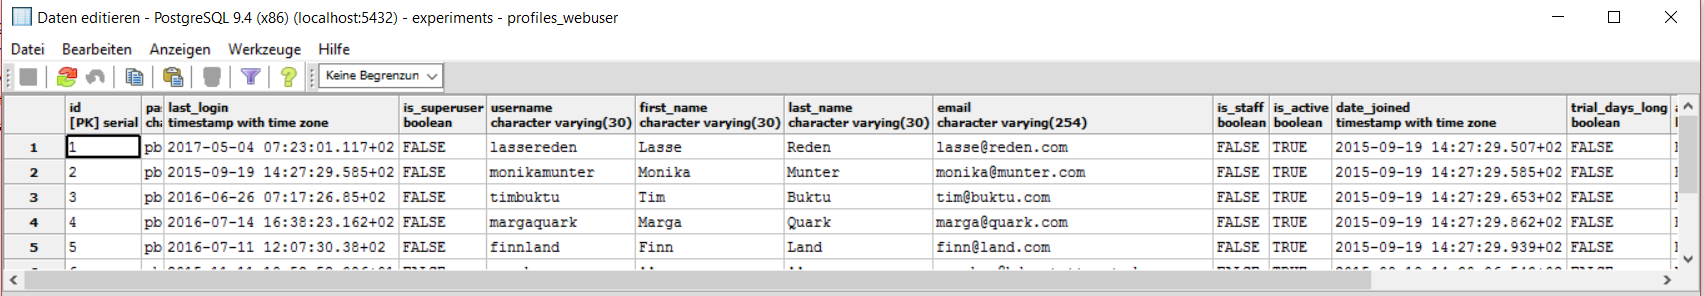

In [1]:
library("IRdisplay")
display_png(file="../img/dbWebUser.png",width=900)

#### Table records_record
Each measurement has a single entry in the table *records_record*. The unique measurement id is used as the primary key. Each measurement belongs to a user, whose id is specified in column *user_id*. There are different types of measurements (training- and HRV- measurements). In this example only measurements of *record_type_id=1* (HRV-measurements) shall be regarded. Moreover, for each measurement the start- and endtime are contained in columns *start* and *end*, respectively. 

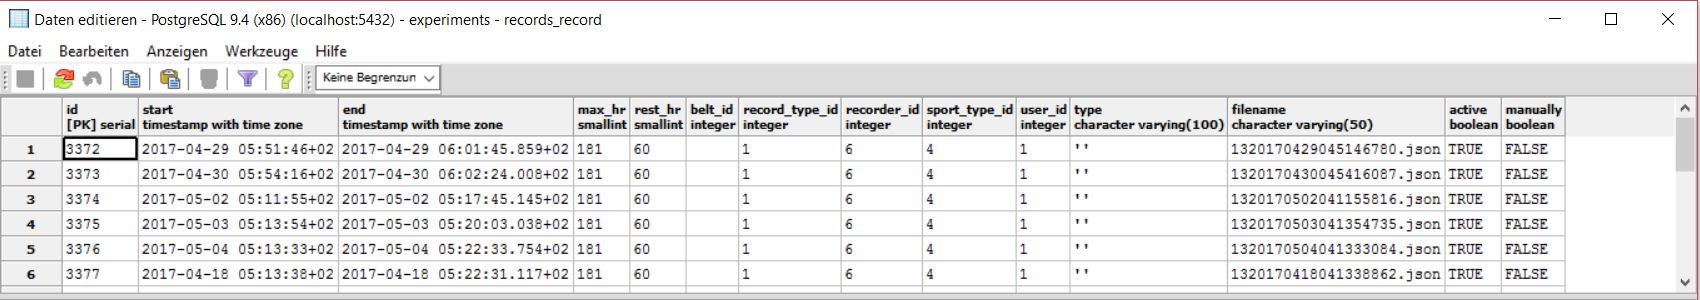

In [2]:
display_png(file="../img/dbrecord.png",width=900)

#### Table records_data
Each HRV-measurement lasts between 5 and 10 minutes. Within such a measurement at each heartbeat, the RR-distance between successive heartbeats (*rr* in ms) and the current heart rate (*hr* in beats/second) are sampled. Each row in the table *records_data* belongs to a unique sample. It has an unique *id* (primary key), a timestamp, the *rr*- and *hr*-value
and a *record_id*. The *record_id* specifies to which measurement (row in table *records_record*) the sample belongs to. 

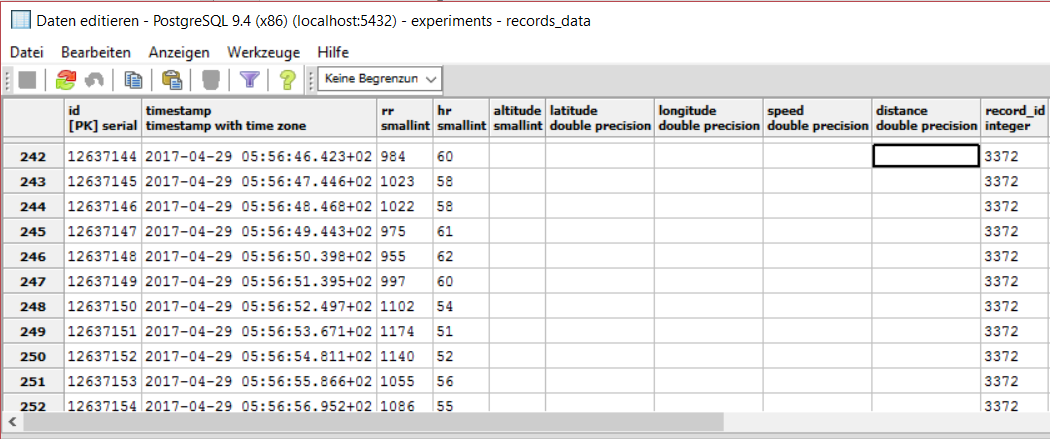

In [3]:
display_png(file="../img/dbdata.png",width=900)

## Connect do Database

In [5]:
options(repos=structure(c(CRAN="http://cloud.r-project.org/")))

In [4]:
library(RPostgreSQL)

Loading required package: DBI


In [6]:
pw<-{
    "hrvanalyzer"
}
drv<-dbDriver("PostgreSQL")
conExp <- dbConnect(drv,dbname="experiments",host="localhost",port=5432,user="postgres",password=pw)

### Check if tables exist

In [7]:
print(dbExistsTable(conExp,"profiles_webuser"))
print(dbExistsTable(conExp,"records_record"))
print(dbExistsTable(conExp,"records_data"))

[1] TRUE
[1] TRUE
[1] TRUE


## SQL Query on joined tables
General introduction in PostgreSQL see (https://www.postgresql.org/docs/8.4/static/queries-table-expressions.html)[https://www.postgresql.org/docs/8.4/static/queries-table-expressions.html]

### Query registered users

In [8]:
df_postgres <- dbGetQuery(conExp, "SELECT id,username,last_name,last_login from profiles_webuser")

In [9]:
df_postgres[order(df_postgres$last_login),]

,id,username,last_name,last_login
1,2,monikamunter,Munter,2015-09-19 14:27:29
2,8,dheinzelmann,,2015-10-04 21:11:29
3,6,maucher,,2015-11-11 19:52:52
7,7,johannes.maucher,,2016-05-18 07:12:29
4,3,timbuktu,Buktu,2016-06-26 07:17:26
6,5,finnland,Land,2016-07-11 12:07:30
8,4,margaquark,Quark,2016-07-14 16:38:23
5,1,lassereden,Reden,2017-05-04 07:23:01


### Query all morning HRV-Measurements (entire time-series data, not only calculated HRV-Parameters):
In the code snippet below all measured samples from morning measurements *(record_type=1)* of a predefined user *(mid=1)* are queried. 

In [10]:
mid<-1   #Choose ID of user
mystr2=sprintf("SELECT * FROM records_record INNER JOIN 
records_data ON records_record.id = records_data.record_id 
WHERE records_record.user_id=%d AND records_record.record_type_id=1",mid)
morningMeas<-dbGetQuery(conExp, mystr2)

In [11]:
morningMeas<-morningMeas[order(morningMeas$start),]
n_meas<-length(unique(morningMeas$id))
n_samp<-dim(morningMeas)[1]
sprintf("Number of measurements of user %d: %d",mid,n_meas)
sprintf("Number of samples in all %d measurements: %d",n_meas,n_samp)

[1] "Number of measurements of user 1: 16"

[1] "Number of samples in all 16 measurements: 5776"

### Head and tail of all samples of specified user

In [12]:
head(morningMeas[c("id","start","timestamp","hr","rr")])
tail(morningMeas[c("id","start","timestamp","hr","rr")])

,id,start,timestamp,hr,rr
1808,3377,2017-04-18 05:13:38,2017-04-18 05:13:39,42,1414
1809,3377,2017-04-18 05:13:38,2017-04-18 05:13:41,36,1653
1810,3377,2017-04-18 05:13:38,2017-04-18 05:13:42,42,1425
1811,3377,2017-04-18 05:13:38,2017-04-18 05:13:43,50,1187
1812,3377,2017-04-18 05:13:38,2017-04-18 05:13:45,44,1345
1813,3377,2017-04-18 05:13:38,2017-04-18 05:13:46,39,1517


,id,start,timestamp,hr,rr
1802,3376,2017-05-04 05:13:33,2017-05-04 05:22:26,39,1523
1803,3376,2017-05-04 05:13:33,2017-05-04 05:22:27,45,1312
1804,3376,2017-05-04 05:13:33,2017-05-04 05:22:29,46,1296
1805,3376,2017-05-04 05:13:33,2017-05-04 05:22:30,37,1604
1806,3376,2017-05-04 05:13:33,2017-05-04 05:22:32,39,1502
1807,3376,2017-05-04 05:13:33,2017-05-04 05:22:33,39,1538


### Head of a single measurement

In [66]:
single<-morningMeas[morningMeas$id==3376,c("timestamp","hr")]
single<-single[order(single$timestamp),]
sprintf("Number of samples in this measurement: %d",dim(single)[1])
tail(single,30)

[1] "Number of samples in this measurement: 400"

,timestamp,hr
1778,2017-05-04 05:21:51,46
1779,2017-05-04 05:21:53,42
1780,2017-05-04 05:21:54,41
1781,2017-05-04 05:21:56,43
1782,2017-05-04 05:21:57,38
1783,2017-05-04 05:21:59,39
1784,2017-05-04 05:22:00,40
1785,2017-05-04 05:22:01,47
1786,2017-05-04 05:22:03,44
1787,2017-05-04 05:22:04,40


### Query for each ID the corresponding date and start time of measurement:

In [62]:
mystr3=sprintf("SELECT id,start FROM records_record WHERE records_record.user_id = %d AND records_record.record_type_id=1 ORDER BY start",mid)
startTimes<-dbGetQuery(conExp, mystr3)

In [109]:
head(startTimes,40)
dim(startTimes)
#startTimes[startTimes$id==meas_id,]$start
#startTimes[["id"]]

id,start
3377,2017-04-18 05:13:38
3379,2017-04-19 05:22:17
3381,2017-04-20 05:25:15
3383,2017-04-21 05:22:12
3385,2017-04-22 05:56:47
3387,2017-04-23 06:08:26
3389,2017-04-24 05:12:14
3391,2017-04-25 05:12:48
3393,2017-04-26 05:12:54
3395,2017-04-27 05:13:03


[1] 16  2

[1] "2017-04-30 05:54:16 CEST"

## Calculate Mean HR for each Measurement

By applying the *aggregate*-function for each measurement the mean heart-rate over all samples of the measurement is calculated.

In [64]:
meanHR<-aggregate(morningMeas$hr, by=list(Id=morningMeas$id,date=morningMeas$start),FUN=mean, na.rm=TRUE)
meanHR<-meanHR[order(meanHR$date),]
head(meanHR,30)

Id,date,x
3377,2017-04-18 05:13:38,42.89005
3379,2017-04-19 05:22:17,42.96065
3381,2017-04-20 05:25:15,43.69697
3383,2017-04-21 05:22:12,45.13528
3385,2017-04-22 05:56:47,45.32967
3387,2017-04-23 06:08:26,44.92188
3389,2017-04-24 05:12:14,40.29766
3391,2017-04-25 05:12:48,43.05085
3393,2017-04-26 05:12:54,45.61499
3395,2017-04-27 05:13:03,42.90291


## Calculate descriptive statistics of all measurements
In the following loop for each measurement the mean, standard deviation, min, max and different quantiles are calculated. The mean is calculated not only over the entire measurements, but also over the last 100, last 200 and last 300 samples.

In [67]:
all<-c()
last100<-c()
last200<-c()
last300<-c()
minAll<-c()
maxAll<-c()
sdAll<-c()
q25All<-c()
q50All<-c()
q75All<-c()
#startdate<-c()
allids<-startTimes[["id"]]
for (idx in allids){
    single<-morningMeas[morningMeas$id==idx,c("timestamp","hr")]
    single<-single[order(single$timestamp),]
    hrall<-mean(single$hr,na.rm=TRUE)
    std<-sd(single$hr,na.rm=TRUE)
    hr100<-mean(tail(single$hr,100),na.rm=TRUE)
    hr200<-mean(tail(single$hr,200),na.rm=TRUE)
    hr300<-mean(tail(single$hr,300),na.rm=TRUE)
    all<-c(all,hrall)
    q<-quantile(single$hr,na.rm=TRUE)
    last100<-c(last100,hr100)
    last200<-c(last200,hr200)
    last300<-c(last300,hr300)
    minAll<-c(minAll,q["0%"])
    maxAll<-c(maxAll,q["100%"])
    sdAll<-c(sdAll,std)
    q25All<-c(q25All,q["25%"])
    q50All<-c(q50All,q["50%"])
    q75All<-c(q75All,q["75%"])
}

## Write measurement statistics into a data frame and save it in csv-file

In [68]:
varLengthHR<-NULL
varLengthHR<-data.frame(id=startTimes[["id"]],date=startTimes[["start"]],Mcomplete=all,Stdcomplete=sdAll,Mlast300=last300,Mlast200=last200,Mlast100=last100,
                       MinCompl=minAll,Q25Compl=q25All,Q50Compl=q50All,Q75Compl=q75All,MaxCompl=maxAll)
rownames(varLengthHR)<-varLengthHR$id
varLengthHR$id<-NULL

In [70]:
tail(varLengthHR,20)

,date,Mcomplete,Stdcomplete,Mlast300,Mlast200,Mlast100,MinCompl,Q25Compl,Q50Compl,Q75Compl,MaxCompl
3377,2017-04-18 05:13:38,42.89005,4.383632,43.49333,41.940,42.88,34,40.00,42,45.0,58
3379,2017-04-19 05:22:17,42.96065,4.853379,42.83000,42.545,41.22,31,39.00,43,47.0,56
3381,2017-04-20 05:25:15,43.69697,4.705778,43.69697,43.315,42.84,33,40.00,44,47.0,58
3383,2017-04-21 05:22:12,45.13528,5.638041,44.98000,45.080,44.10,32,41.00,45,49.0,62
3385,2017-04-22 05:56:47,45.32967,4.717484,44.90000,44.345,43.75,35,42.00,45,49.0,58
3387,2017-04-23 06:08:26,44.92188,4.990879,44.67667,44.890,43.95,31,41.75,45,49.0,57
3389,2017-04-24 05:12:14,40.29766,3.925698,40.29766,39.855,39.55,32,37.00,40,43.0,49
3391,2017-04-25 05:12:48,43.05085,5.095095,43.05085,42.335,41.99,30,40.00,42,47.0,59
3393,2017-04-26 05:12:54,45.61499,4.712356,45.88667,45.230,45.24,32,42.00,46,49.0,56
3395,2017-04-27 05:13:03,42.90291,4.539129,42.22667,41.925,42.31,27,40.00,42,45.0,57


In [71]:
write.table(varLengthHR,"../data/maucherExperimentVarHR-2017-05-04.csv",sep = ",")

In [72]:
dbDisconnect(conExp)

[1] TRUE

## Plot single measurements

In [73]:
library(ggplot2)

In [94]:
meas_id=3373
single<-morningMeas[morningMeas$id==meas_id,c("timestamp","hr")]
single<-single[order(single$timestamp),]
minHR=min(single$hr)
maxHR=max(single$hr)
minHR
maxHR

[1] 35

[1] 60

In [78]:
start<-1
end<-300
end<-min(end,dim(single$hr)[1])
xt<-start:end

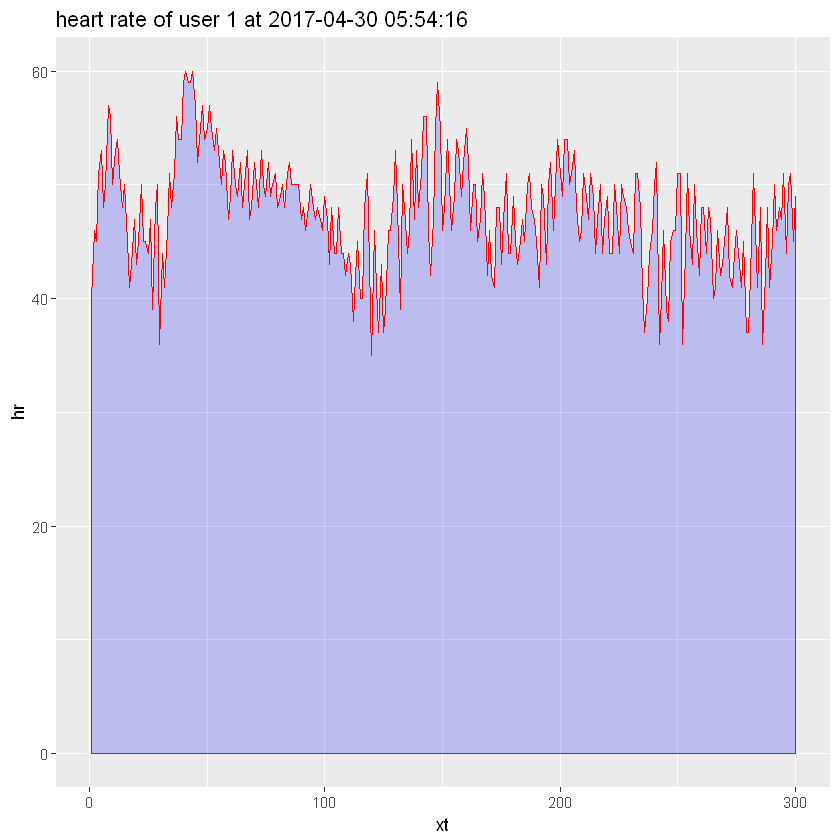

In [117]:
ggplot(data = single[xt,]) + 
geom_area(mapping=aes(x=xt,y=hr),color="red",fill="blue",alpha=.2) +
labs(title=sprintf("heart rate of user %d at %s",mid,startTimes[startTimes$id==meas_id,]$start)) 

## Plot daily mean Heart Rate

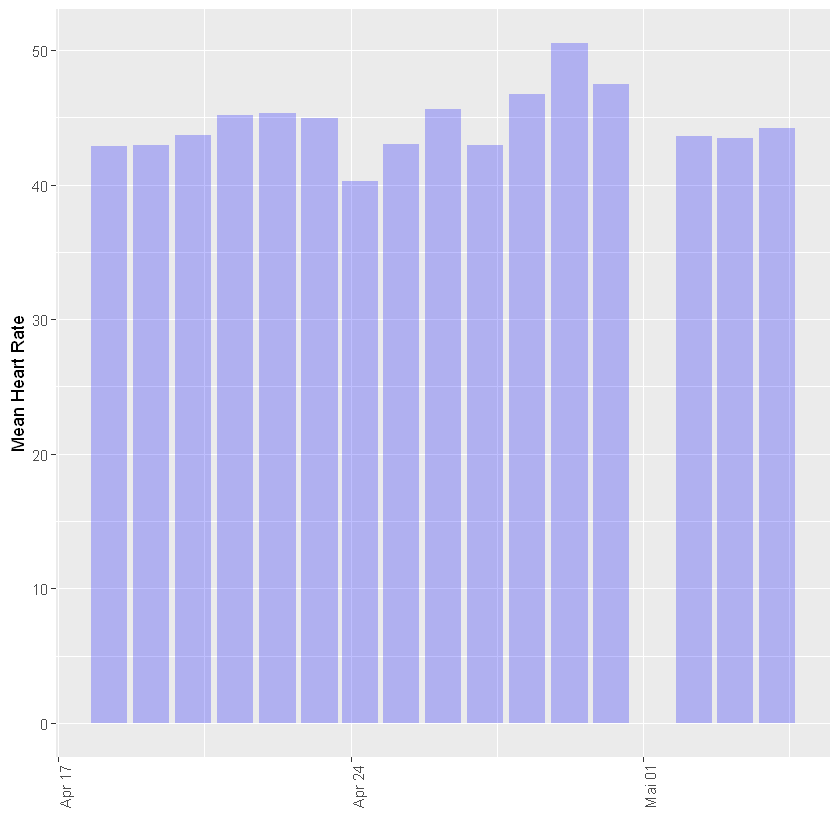

In [135]:
ggplot(data = varLengthHR) + 
geom_col(mapping=aes(x=date,y=Mcomplete),fill="blue",alpha=.25)+
labs(y="Mean Heart Rate",x="")+ 
theme(axis.text.x = element_text(angle = 90))

## Plot daily Quantiles of Heart Rate Measurements

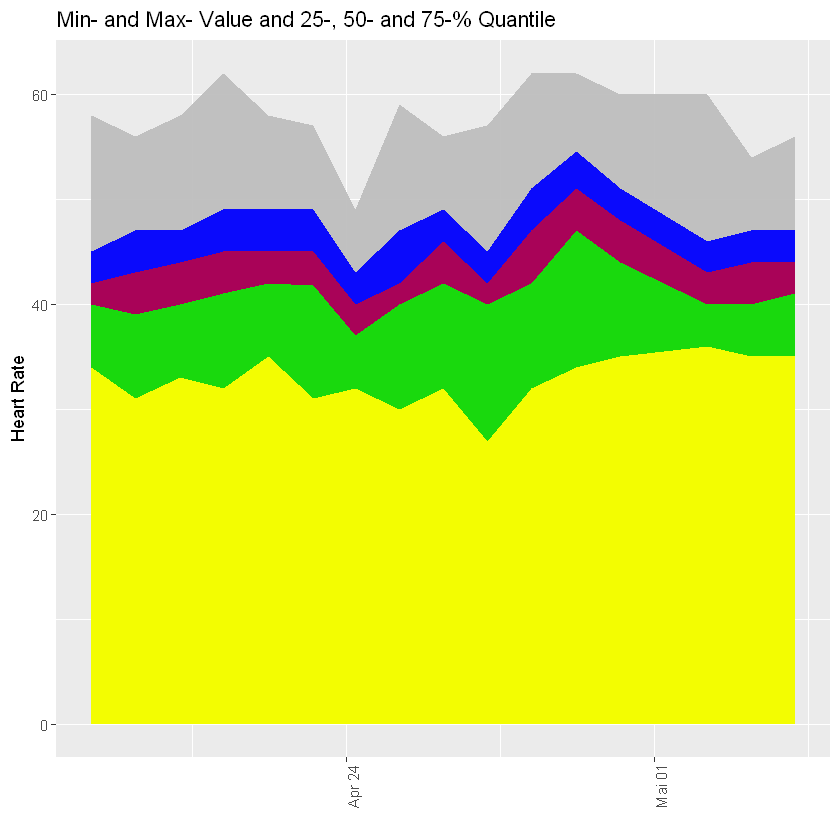

In [140]:
ggplot(data = varLengthHR) + 
geom_area(mapping=aes(x=date,y=MaxCompl),fill="gray",alpha=.95)+
geom_area(mapping=aes(x=date,y=Q75Compl),fill="blue",alpha=.95)+
geom_area(mapping=aes(x=date,y=Q50Compl),fill="red",alpha=.65)+
geom_area(mapping=aes(x=date,y=Q25Compl),fill="green",alpha=.85)+
geom_area(mapping=aes(x=date,y=MinCompl),fill="yellow",alpha=.95)+
labs(y="Heart Rate",x="")+ 
theme(axis.text.x = element_text(angle = 90))+
labs(title="Min- and Max- Value and 25-, 50- and 75-% Quantile") 